# Rekurencyjne Sieci Neuronowe (RNN)
### Wariant 4
### Zadania:

### (a) Prognozowanie liczby pasażerów w transporcie publicznym.

### (b) Wykrywanie anomalii w ciśnieniu w systemach wodnych.

### (c) Rozpoznawanie wzorców użytkowania aplikacji mobilnych.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ustawienie ziarna losowości dla powtarzalności wyników
np.random.seed(42)
tf.random.set_seed(42)

# Zadanie 1 (Wariant 4a): Prognozowanie liczby pasażerów w transporcie publicznym
### Model LSTM (Regression) do przewidywania przyszłej liczby pasażerów na podstawie danych historycznych. Dane są symulowane jako sinusoida z trendem i szumem (odzwierciedlając cykliczność dobową/tygodniową transportu).


c:\Users\Maciek\Desktop\NaukaODanychII\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trenowanie modelu pasażerów...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


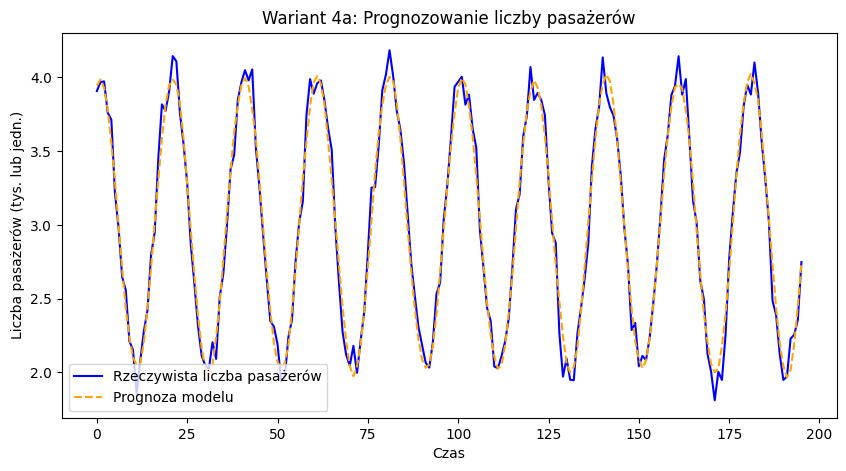

In [8]:
# 1. Generowanie danych (Symulacja: sinusoida + trend + szum)
def generate_passenger_data(n_samples=1000, freq=0.05, noise=0.1):
    x = np.arange(n_samples)
    # Symulacja: Cykliczność + stała baza (żeby nie było ujemnych pasażerów) + losowość
    y = np.sin(2 * np.pi * freq * x) + 3.0 + np.random.normal(0, noise, size=n_samples)
    return y.reshape(-1, 1)

data_passengers = generate_passenger_data()

# 2. Normalizacja danych (LSTM wymaga skali 0-1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_passengers)

# 3. Przygotowanie sekwencji czasowych (look_back)
def create_dataset(dataset, look_back=10):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20
X, y = create_dataset(data_scaled, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Podział na trening i test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 4. Budowa modelu LSTM (Regresja)
model_passengers = Sequential()
model_passengers.add(LSTM(50, input_shape=(look_back, 1)))
model_passengers.add(Dense(1)) 

model_passengers.compile(optimizer='adam', loss='mean_squared_error')

print("Trenowanie modelu pasażerów...")
model_passengers.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

# 5. Prognoza i Wykres
predicted = model_passengers.predict(X_test)
predicted_real = scaler.inverse_transform(predicted)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(y_test_real, label='Rzeczywista liczba pasażerów', color='blue')
plt.plot(predicted_real, label='Prognoza modelu', color='orange', linestyle='--')
plt.title('Wariant 4a: Prognozowanie liczby pasażerów')
plt.xlabel('Czas')
plt.ylabel('Liczba pasażerów (tys. lub jedn.)')
plt.legend()
plt.show()


# Komórka 3: Zadanie 4b - Wykrywanie anomalii w ciśnieniu
### To zadanie klasyfikacji binarnej (0 - norma, 1 - awaria).


Trenowanie modelu ciśnienia...

Dokładność wykrywania anomalii ciśnienia: 99.00%


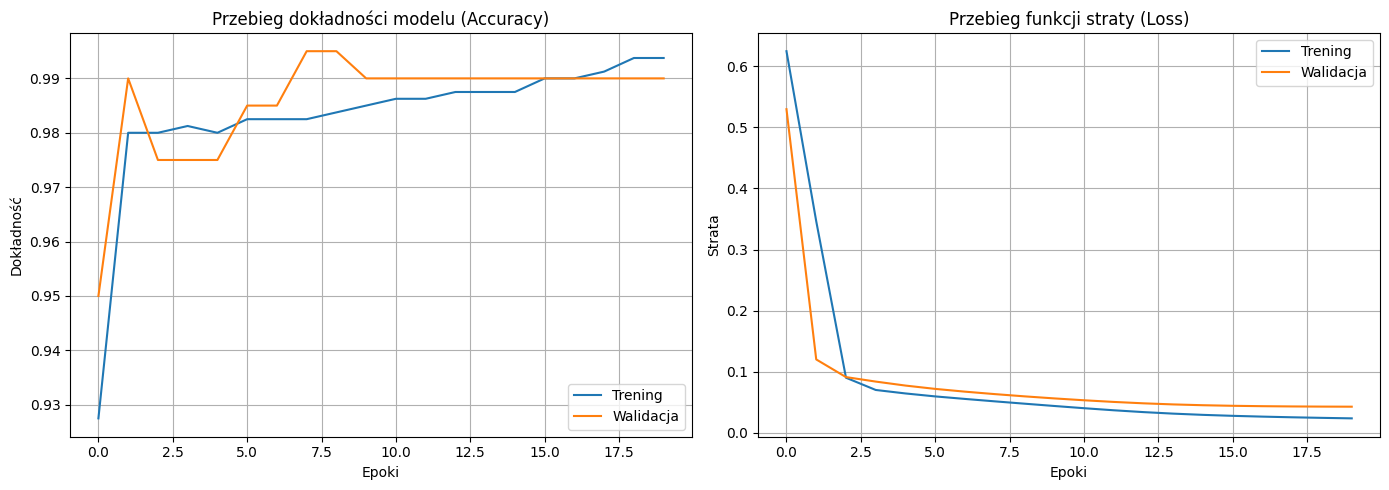

In [14]:
def generate_pressure_data(n_samples=1000, timesteps=10):
    # Stan normalny: szum wokół 0
    X = np.random.normal(0, 1, (n_samples, timesteps))
    y = np.zeros(n_samples)
    
    # Generowanie anomalii (nagłe skoki ciśnienia)
    n_anomalies = n_samples // 10
    anomaly_indices = np.random.choice(n_samples, size=n_anomalies, replace=False)
    
    # Anomalia: skok średniej wartości do 1.5 (trudniejsze do wykrycia)
    X[anomaly_indices] += np.random.normal(1.5, 1, (len(anomaly_indices), timesteps))
    y[anomaly_indices] = 1 
    
    return X, y

X_pres, y_pres = generate_pressure_data()
X_pres = X_pres.reshape((X_pres.shape[0], X_pres.shape[1], 1))

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pres, y_pres, test_size=0.2, random_state=42)

# 2. Budowa modelu (Klasyfikacja binarna)
model_pressure = Sequential()
model_pressure.add(LSTM(32, input_shape=(X_pres.shape[1], 1)))
model_pressure.add(Dense(1, activation='sigmoid')) 

model_pressure.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Trenowanie modelu ciśnienia...")
history = model_pressure.fit(X_train_p, y_train_p, epochs=20, batch_size=32, validation_data=(X_test_p, y_test_p), verbose=0)

# 3. Ocena
loss, accuracy = model_pressure.evaluate(X_test_p, y_test_p, verbose=0)
print(f"\nDokładność wykrywania anomalii ciśnienia: {accuracy*100:.2f}%")

# Ustawienia wykresu
plt.figure(figsize=(14, 5))

# Wykres 1: Dokładność (Accuracy) w czasie treningu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trening')
plt.plot(history.history['val_accuracy'], label='Walidacja')
plt.title('Przebieg dokładności modelu (Accuracy)')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)

# Wykres 2: Funkcja straty (Loss) w czasie treningu
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.title('Przebieg funkcji straty (Loss)')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# Komórka 4: Zadanie 4c - Rozpoznawanie wzorców aplikacji
### To zadanie klasyfikacji wieloklasowej (rozpoznawanie 3 różnych typów zachowań).

Trenowanie modelu aplikacji...
Dokładność rozpoznawania aplikacji: 98.67%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


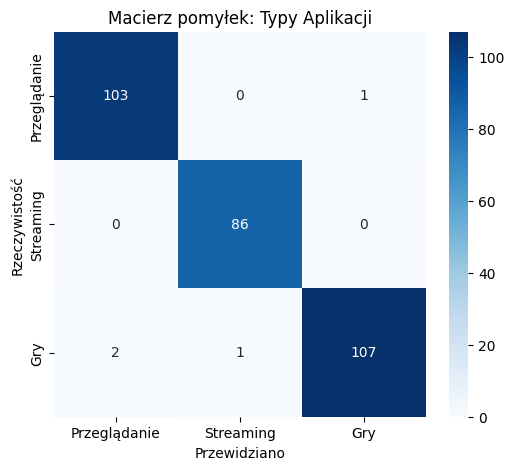

In [10]:
# 1. Generowanie danych (3 klasy: 0=Przeglądanie, 1=Streaming, 2=Gry)
def generate_app_data(n_classes=3, samples_per_class=500, timesteps=20):
    X, y = [], []
    for cls in range(n_classes):
        for _ in range(samples_per_class):
            noise = np.random.normal(0, 0.5, timesteps) # Większy szum 0.5
            if cls == 0: 
                seq = np.random.normal(0, 0.5, timesteps) # Tylko szum
            elif cls == 1:
                seq = np.sin(np.linspace(0, 4*np.pi, timesteps)) + noise # Zaszumiona fala
            else:
                seq = np.sin(np.linspace(0, 8*np.pi, timesteps)) + noise # Szybka zaszumiona fala
            X.append(seq)
            y.append(cls)
    X = np.array(X).reshape(-1, timesteps, 1)
    y = to_categorical(y, num_classes=n_classes)
    return X, y

X_apps, y_apps = generate_app_data()
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_apps, y_apps, test_size=0.2, random_state=42)

# 2. Budowa modelu (Klasyfikacja wieloklasowa)
model_apps = Sequential()
model_apps.add(LSTM(64, input_shape=(X_apps.shape[1], 1)))
model_apps.add(Dense(3, activation='softmax')) 

model_apps.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Trenowanie modelu aplikacji...")
model_apps.fit(X_train_a, y_train_a, epochs=15, batch_size=32, validation_data=(X_test_a, y_test_a), verbose=0)

# 3. Ocena i Macierz Pomyłek
loss, accuracy = model_apps.evaluate(X_test_a, y_test_a, verbose=0)
print(f"Dokładność rozpoznawania aplikacji: {accuracy*100:.2f}%")

y_pred = np.argmax(model_apps.predict(X_test_a), axis=1)
y_true = np.argmax(y_test_a, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Przeglądanie', 'Streaming', 'Gry'],
            yticklabels=['Przeglądanie', 'Streaming', 'Gry'])
plt.title('Macierz pomyłek: Typy Aplikacji')
plt.xlabel('Przewidziano')
plt.ylabel('Rzeczywistość')
plt.show()